In [ ]:
from collections import abc, Counter
from functools import lru_cache
from itertools import chain
import matplotlib.pyplot as plt
import mmh3
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from htools import hdir, eprint, assert_raises, flatten

In [ ]:
sents = [
    'I walked to the store so I hope it is not closed.',
    'The theater is closed today and the sky is grey.',
    'His dog is brown while hers is grey.'
]
labels = [0, 1, 1]

In [ ]:
class Data(Dataset):
    
    def __init__(self, sentences, labels, seq_len):
        x = [s.split(' ') for s in sentences]
        self.w2i = self.make_w2i(x)
        self.seq_len = seq_len
        self.x = self.encode(x)
        self.y = torch.tensor(labels)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.y)
    
    def make_w2i(self, tok_rows):
        return {k: i for i, (k, v) in 
                enumerate(Counter(chain(*tok_rows)).most_common(), 1)}
    
    def encode(self, tok_rows):
        enc = np.zeros((len(tok_rows), self.seq_len), dtype=int)
        for i, row in enumerate(tok_rows):
            trunc = [self.w2i.get(w, 0) for w in row[:self.seq_len]]
            enc[i, :len(trunc)] = trunc
        return torch.tensor(enc)

In [ ]:
ds = Data(sents, labels, 10)
ds[1]

(tensor([13, 14,  1, 15, 16, 17,  3, 18,  1,  4]), tensor(1))

In [ ]:
dl = DataLoader(ds, batch_size=3)
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]), tensor([0, 1, 1]))

In [ ]:
x.shape

torch.Size([3, 10])

In [ ]:
ds.x

tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
        [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
        [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]])

In [ ]:
ds.w2i

{'is': 1,
 'I': 2,
 'the': 3,
 'grey.': 4,
 'walked': 5,
 'to': 6,
 'store': 7,
 'so': 8,
 'hope': 9,
 'it': 10,
 'not': 11,
 'closed.': 12,
 'The': 13,
 'theater': 14,
 'closed': 15,
 'today': 16,
 'and': 17,
 'sky': 18,
 'His': 19,
 'dog': 20,
 'brown': 21,
 'while': 22,
 'hers': 23}

For now, just convert int to str and take hash. Another option that is meant for ints is Knuth's multiplicative method:

hash(i) = i*2654435761 mod 2^32

But we'd need to make this dependent on a random seed.

In [ ]:
def probabilistic_hash_item(x, n_buckets, mode=int, n_hashes=3):
    """Slightly hacky way to probabilistically hash an integer by
    first converting it to a string.
    
    Parameters
    ----------
    x: int
        The integer or string to hash.
    n_buckets: int
        The number of buckets that items will be mapped to. Typically 
        this would occur outside the hashing function, but since 
        the intended use case is so narrow here it makes sense to me 
        to include it here.
    mode: type
        The type of input you want to hash. This is user-provided to prevent
        accidents where we pass in a different item than intended and hash 
        the wrong thing. One of (int, str). When using this inside a
        BloomEmbedding layer, this must be `int` because there are no
        string tensors. When used inside a dataset or as a one-time
        pre-processing step, you can choose either as long as you
        pass in the appropriate inputs.
    n_hashes: int
        The number of times to hash x, each time with a different seed.
        
    Returns
    -------
    list[int]: A list of integers with length `n_hashes`, where each integer
        is in [0, n_buckets).
    """
    # Check type to ensure we don't accidentally hash Tensor(5) instead of 5.
    assert isinstance(x, mode), f'Input `x` must have type {mode}.'
    return [mmh3.hash(str(x), i, signed=False) % n_buckets 
            for i in range(n_hashes)]

In [ ]:
def probabilistic_hash_tensor(x_r2, n_buckets, n_hashes=3, pad_idx=0):
    """Hash a rank 2 LongTensor.
    
    Parameters
    ----------
    x_r2: torch.LongTensor
        Rank 2 tensor of integers. Shape: (bs, seq_len)
    n_buckets: int
        Number of buckets to hash items into (i.e. the number of 
        rows in the embedding matrix). Typically a moderately large
        prime number, like 251 or 997.
    n_hashes: int
        Number of hashes to take for each input index. This determines
        the number of rows of the embedding matrix that will be summed
        to get the representation for each word. Typically 2-5.
    pad_idx: int or None
        If you want to pad sequences with vectors of zeros, pass in an
        integer (same as the `padding_idx` argument to nn.Embedding).
        If None, no padding index will be used. The sequences must be
        padded before passing them into this function.
        
    Returns
    -------
    torch.LongTensor: Tensor of indices where each row corresponds
        to one of the input indices. Shape: (bs, seq_len, n_hashes)
    """
    return torch.tensor(
        [[probabilistic_hash_item(x.item(), n_buckets, int, n_hashes) 
          if x != pad_idx else [pad_idx]*n_hashes for x in row]
         for row in x_r2]
    )

In [ ]:
for i, row in enumerate(x):
    print(i)
    print(row)
    print([x.item() for x in row], end='\n\n')

0
tensor([ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1])
[2, 5, 6, 3, 7, 8, 2, 9, 10, 1]

1
tensor([13, 14,  1, 15, 16, 17,  3, 18,  1,  4])
[13, 14, 1, 15, 16, 17, 3, 18, 1, 4]

2
tensor([19, 20,  1, 21, 22, 23,  1,  4,  0,  0])
[19, 20, 1, 21, 22, 23, 1, 4, 0, 0]



In [ ]:
probabilistic_hash_tensor(x, 11)

tensor([[[ 8,  2,  7],
         [ 2,  8,  1],
         [ 6,  6, 10],
         [10,  5,  5],
         [ 6,  9,  7],
         [ 5,  9,  4],
         [ 8,  2,  7],
         [ 5, 10,  8],
         [ 7,  8,  6],
         [ 6, 10,  6]],

        [[ 2,  5,  1],
         [ 9,  8,  8],
         [ 6, 10,  6],
         [ 8,  1, 10],
         [ 6,  3,  9],
         [ 2,  6,  9],
         [10,  5,  5],
         [10,  5,  0],
         [ 6, 10,  6],
         [ 4,  8,  6]],

        [[ 2, 10,  6],
         [ 1,  7,  8],
         [ 6, 10,  6],
         [ 2,  7,  1],
         [ 9,  4,  8],
         [ 5,  3,  3],
         [ 6, 10,  6],
         [ 4,  8,  6],
         [ 0,  0,  0],
         [ 0,  0,  0]]])

In [ ]:
probabilistic_hash_tensor(x[0, None], 11)

tensor([[[ 8,  2,  7],
         [ 2,  8,  1],
         [ 6,  6, 10],
         [10,  5,  5],
         [ 6,  9,  7],
         [ 5,  9,  4],
         [ 8,  2,  7],
         [ 5, 10,  8],
         [ 7,  8,  6],
         [ 6, 10,  6]]])

In [ ]:
probabilistic_hash_tensor(x[2, None], 11)

tensor([[[ 2, 10,  6],
         [ 1,  7,  8],
         [ 6, 10,  6],
         [ 2,  7,  1],
         [ 9,  4,  8],
         [ 5,  3,  3],
         [ 6, 10,  6],
         [ 4,  8,  6],
         [ 0,  0,  0],
         [ 0,  0,  0]]])

In [ ]:
x

tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
        [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
        [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]])

In [ ]:
[probabilistic_hash_item(n.item(), 11) for n in x[0]]

[[8, 2, 7],
 [2, 8, 1],
 [6, 6, 10],
 [10, 5, 5],
 [6, 9, 7],
 [5, 9, 4],
 [8, 2, 7],
 [5, 10, 8],
 [7, 8, 6],
 [6, 10, 6]]

In [ ]:
for i in range(0, 200, 17):
    print(probabilistic_hash_item(i, 11))

[9, 8, 1]
[2, 6, 9]
[8, 2, 7]
[2, 5, 7]
[10, 10, 2]
[0, 10, 4]
[3, 8, 4]
[6, 5, 0]
[6, 10, 8]
[4, 4, 0]
[7, 1, 0]
[10, 4, 6]


In [ ]:
for row in [s.split(' ') for s in sents]:
    eprint(list(zip(row, (probabilistic_hash_item(word, 11, str) for word in row))))
    print()

 0: ('I', [0, 5, 5])
 1: ('walked', [2, 5, 1])
 2: ('to', [10, 4, 6])
 3: ('the', [4, 1, 4])
 4: ('store', [4, 6, 3])
 5: ('so', [7, 8, 8])
 6: ('I', [0, 5, 5])
 7: ('hope', [1, 2, 7])
 8: ('it', [3, 9, 0])
 9: ('is', [3, 1, 3])
10: ('not', [6, 10, 4])
11: ('closed.', [3, 6, 10])

 0: ('The', [1, 6, 9])
 1: ('theater', [8, 10, 2])
 2: ('is', [3, 1, 3])
 3: ('closed', [5, 5, 0])
 4: ('today', [3, 10, 8])
 5: ('and', [7, 2, 4])
 6: ('the', [4, 1, 4])
 7: ('sky', [1, 2, 9])
 8: ('is', [3, 1, 3])
 9: ('grey.', [7, 6, 7])

 0: ('His', [0, 10, 3])
 1: ('dog', [8, 6, 6])
 2: ('is', [3, 1, 3])
 3: ('brown', [9, 8, 9])
 4: ('while', [9, 2, 8])
 5: ('hers', [0, 5, 4])
 6: ('is', [3, 1, 3])
 7: ('grey.', [7, 6, 7])



In [ ]:
assert isinstance(np.array(sents), (list, np.ndarray)), 'np array'
assert isinstance(sents, (list, np.ndarray)), 'list'
with assert_raises(AssertionError):
    assert isinstance(x, (list, np.ndarray)), 'torch tensor'

As expected, got AssertionError(torch tensor).


In [ ]:
for t in (abc.Iterable, abc.Collection, abc.Container, abc.Sequence, abc.MutableSequence):
    tname = t.__name__
    print(tname, 'tensor', isinstance(x, t))
    print(tname, 'list', isinstance(sents, t))
    print(tname, 'array', isinstance(np.array(sents), t))
    print()

Iterable tensor True
Iterable list True
Iterable array True

Collection tensor True
Collection list True
Collection array True

Container tensor True
Container list True
Container array True

Sequence tensor False
Sequence list True
Sequence array False

MutableSequence tensor False
MutableSequence list True
MutableSequence array False



# To do:
- [x] maybe handle padding differently (i.e. just a row of zeros as usual. Should this happen in hash_int, hash_int_tensor, or BloomEmbedding?)
- maybe use fastai embedding() instead of nn.Embedding? Check if the weight init method might help for this.
- maybe use nn.embeddingbag? (note: people report this is much slower on CPU, and possibly slower on GPU even though it's supposed to be faster)
- experiment with different numbers of embeddings and hashes. Try to find guidelines for what reasonable choices are to prevent collisions. 
    - Eventually, maybe better to let user input vocab size and choose prob of collision, then automatically select values for n_emb and n_hashes. 
- check to make sure indices are working correctly after switching hash_int_tensor to take only 2d tensors. Also consider if this is the preferred way to do this.
- should we let user choose between mean and sum? Wonder if mean would be better bc we could try different values of n_hashes while still loading pre-trained embeddings (bc scale is standardized)? But that probably doesn't work bc the hashes will be different anyway.

In [ ]:
emb = nn.EmbeddingBag(5, 4, mode='sum')
emb.weight

Parameter containing:
tensor([[ 0.5849, -0.1108, -0.1991, -1.1982],
        [-0.5891,  1.5808,  1.4062, -1.5162],
        [-1.0055,  0.1712, -0.5717, -0.2766],
        [ 1.6280, -0.1770, -1.4850, -2.0490],
        [ 0.8724,  0.5324,  0.1913, -0.9653]], requires_grad=True)

In [ ]:
x = torch.Tensor([[1, 2, 1],
                  [3, 2, 0]]).long()
emb(x)

tensor([[-2.1837,  3.3329,  2.2408, -3.3091],
        [ 1.2073, -0.1165, -2.2557, -3.5238]], grad_fn=<EmbeddingBagBackward>)

In [ ]:
class BloomEmbedding(nn.Module):
    """Bloom Embedding layer for memory-efficient word representations.
    Each word is encoded by a combination of rows of the embedding
    matrix. The number of rows can therefore be far lower than the number
    of words in our vocabulary while still providing unique representations.
    
    The reduction in rows allows us to use memory in other ways: 
    a larger embedding dimension, more or larger layers after the embedding,
    or larger batch sizes.
    """
    
    def __init__(self, n_emb=251, emb_dim=100, n_hashes=4, padding_idx=0,
                 pre_hashed=False):
        """
        Parameters
        ----------
        n_emb: int
            Number of rows to create in the embedding matrix. A prime
            number is recommended. Lower numbers will be more 
            memory-efficient but increase the chances of collisions.
        emb_dim: int
            Size of each embedding. If emb_dim=100, each word will
            be represented by a 100-dimensional vector.
        n_hashes: int
            This determines the number of hashes that will be taken
            for each word index, and as a result, the number of rows
            that will be summed to create each unique representation.
            The higher the number, the lower the chances of a collision.
        padding_idx: int or None
            If an integer is provided, this will set aside the corresponding
            row in the embedding matrix as a vector of zeros. If None, no
            padding vector will be allocated.
        pre_hashed: bool
            Pass in True if the input tensor will already be hashed by the time 
            it enters this layer (you may prefer pre-compute the hashes in the
            Dataset to save computation time during training). In this
            scenario, the layer is a simple embedding bag with mode "sum". 
            Pass in False if the inputs will be word indices that have not yet
            been hashed. In this case, hashing will be done inside the `forward`
            call.
            
        Suggested values for a vocab size of ~30,000:
        
        | n_emb | n_hashes | unique combos |
        |-------|----------|---------------|
        | 127   | 5        | 29,998        |
        | 251   | 4        | 29,996        |
        | 997   | 3        | 29,997        |
        | 5,003 | 2        | 29,969        |
        """
        super().__init__()
        self.n_emb = n_emb
        self.emb = nn.Embedding(n_emb, emb_dim, padding_idx=padding_idx)
        self.n_hashes = n_hashes
        self.pad_idx = padding_idx
        self.pre_hashed = pre_hashed
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.LongTensor
            Input tensor of word indices (bs x seq_len) if pre_hashed is False.
            Hashed indices (bs x seq_len x n_hashes) if pre_hashed is False.
            
        Returns
        -------
        torch.FloatTensor: Words encoded with combination of embeddings.
            (bs x seq_len x emb_dim)
        """
        if not self.pre_hashed:
            # (bs, seq_len) -> hash -> (bs, seq_len, n_hashes)
            hashed = probabilistic_hash_tensor(x, 
                                               self.n_emb,
                                               self.n_hashes,
                                               self.pad_idx)
        # (bs, seq_len, n_hashes, emb_dim) -> sum -> (bs, seq_len, emb_dim)
        return self.emb(hashed).sum(-2)

In [ ]:
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]), tensor([0, 1, 1]))

In [ ]:
be = BloomEmbedding(11, 4)
be.emb.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0890,  2.8199,  1.8165, -1.9656],
        [ 1.2061,  0.3585, -0.5961, -1.2669],
        [-1.5584, -2.4416,  1.1176, -0.4356],
        [ 0.1442, -0.2951,  0.8433, -0.1157],
        [-0.2319,  0.6422, -0.1494,  0.2830],
        [ 0.7345,  2.0709,  1.4002,  0.0562],
        [-0.3707,  0.5033,  0.6533, -1.4163],
        [ 0.7275,  0.1103,  1.3854,  0.0924],
        [ 0.3850,  0.0692,  0.1639,  0.3658],
        [-1.2039, -1.9414, -0.2005, -0.4414]], requires_grad=True)

In [ ]:
x

tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
        [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
        [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]])

In [ ]:
for i in range(24):
    print(probabilistic_hash_item(i, 11))

[9, 8, 1]
[6, 10, 6]
[8, 2, 7]
[10, 5, 5]
[4, 8, 6]
[2, 8, 1]
[6, 6, 10]
[6, 9, 7]
[5, 9, 4]
[5, 10, 8]
[7, 8, 6]
[7, 9, 2]
[1, 7, 3]
[2, 5, 1]
[9, 8, 8]
[8, 1, 10]
[6, 3, 9]
[2, 6, 9]
[10, 5, 0]
[2, 10, 6]
[1, 7, 8]
[2, 7, 1]
[9, 4, 8]
[5, 3, 3]


In [ ]:
# (bs x seq_len) -> (bs -> seq_len -> emb_size)
y = be(x)
y.shape

torch.Size([3, 10, 4])

In [ ]:
y[0]

tensor([[ 2.2904,  1.0825,  2.8281, -2.4985],
        [ 3.2287,  3.6471,  2.0098, -4.4070],
        [-0.9388,  0.2589,  2.3995, -0.7704],
        [-1.8995, -0.0147, -0.6485,  0.4076],
        [ 1.9549,  3.0019,  1.6213, -2.2612],
        [ 0.2973,  0.4164,  0.8578,  0.5331],
        [ 2.2904,  1.0825,  2.8281, -2.4985],
        [-0.3233, -1.1196,  1.1995,  0.2997],
        [ 2.2974,  3.0430,  2.8428, -2.5347],
        [ 0.2651,  2.2004,  2.6000, -0.3290]], grad_fn=<SelectBackward>)

In [ ]:
y[1]

tensor([[ 2.2693,  4.1790,  0.4750, -4.2163],
        [ 2.5744,  2.3608,  4.3350,  0.6067],
        [ 0.2651,  2.2004,  2.6000, -0.3290],
        [-1.9458, -1.4528,  4.1191, -2.7502],
        [-0.4390, -0.3015,  2.6817, -0.0136],
        [ 2.3256,  2.4986,  0.9680, -0.8449],
        [-1.8995, -0.0147, -0.6485,  0.4076],
        [-0.2297, -0.9407, -0.9459, -1.4253],
        [ 0.2651,  2.2004,  2.6000, -0.3290],
        [ 2.8123,  2.2446,  3.0328, -1.2341]], grad_fn=<SelectBackward>)

In [ ]:
y[2]

tensor([[-0.4671, -1.4535,  0.4032, -2.0935],
        [ 1.1803,  5.5044,  5.2554, -3.2333],
        [ 0.2651,  2.2004,  2.6000, -0.3290],
        [ 1.0686,  3.3866,  2.7170, -4.7645],
        [ 1.9912,  1.9554,  3.7928,  0.3986],
        [-2.6212, -4.1307,  3.4713, -0.4958],
        [ 0.2651,  2.2004,  2.6000, -0.3290],
        [ 2.8123,  2.2446,  3.0328, -1.2341],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<SelectBackward>)

In [ ]:
for w, i in ds.w2i.items():
    print(w, i, be(torch.tensor([[i]])).detach().numpy().squeeze())
#           .emb.weight[hash_int(i, be.n_emb)])

is 1 [ 0.26507235  2.2003503   2.5999665  -0.32898915]
I 2 [ 2.2903948  1.0824531  2.828073  -2.498523 ]
the 3 [-1.8995289  -0.01470172 -0.6485326   0.40761688]
grey. 4 [ 2.812286   2.24457    3.0328324 -1.2340608]
walked 5 [ 3.2286701  3.6471388  2.009758  -4.4069753]
to 6 [-0.93877876  0.2589332   2.3995147  -0.7704108 ]
store 7 [ 1.9548693  3.0019045  1.6212814 -2.2612271]
so 8 [0.29734743 0.41637933 0.85779124 0.5330522 ]
hope 9 [-0.3232504  -1.1195885   1.1994998   0.29972154]
it 10 [ 2.2973628  3.042996   2.8428445 -2.534657 ]
not 11 [ 0.8497246  1.4343383  0.8743619 -3.7337801]
closed. 12 [-3.043953  -1.0598472  3.3869708 -4.2589087]
The 13 [ 2.2692842  4.179036   0.4749601 -4.2163124]
theater 14 [2.5744486  2.3608148  4.334958   0.60669684]
closed 15 [-1.9457765 -1.452824   4.1191187 -2.7502215]
today 16 [-0.43895298 -0.30150518  2.6817129  -0.01360181]
and 17 [ 2.325552    2.498587    0.9679917  -0.84489024]
sky 18 [-0.22965312 -0.9407249  -0.9459034  -1.4252954 ]
His 19 [-0.4

In [ ]:
hashed = probabilistic_hash_tensor(torch.tensor([23]).unsqueeze(0), 11, 4)
hashed

tensor([[[5, 3, 3, 8]]])

In [ ]:
be.emb.weight[hashed].sum(2)

tensor([[[-2.6212, -4.1307,  3.4713, -0.4958]]], grad_fn=<SumBackward1>)

In [ ]:
def unique_combos(tups):
    return len(set(tuple(sorted(x)) for x in tups))

In [ ]:
def hash_all_idx(vocab_size, n_buckets, n_hashes):
    return [probabilistic_hash_item(i, n_buckets, int, n_hashes) 
            for i in range(vocab_size)]

In [ ]:
buckets2hashes = {127: 5,
                  251: 4,
                  997: 3,
                  5_003: 2}
for b, h in buckets2hashes.items():
    tups = hash_all_idx(30_000, b,  h)
    unique = unique_combos(tups)
    print('Buckets:', b, 'Hashes:', h, 'Unique combos:', unique,
          '% unique:', round(unique/30_000, 5))

Buckets: 127 Hashes: 5 Unique combos: 29998 % unique: 0.99993
Buckets: 251 Hashes: 4 Unique combos: 29996 % unique: 0.99987
Buckets: 997 Hashes: 3 Unique combos: 29997 % unique: 0.9999
Buckets: 5003 Hashes: 2 Unique combos: 29969 % unique: 0.99897


In [ ]:
def eval_n_buckets(vocab_size, hash_sizes, bucket_sizes):
    for bs in bucket_sizes:
        for hs in hash_sizes:
            tups = hash_all_idx(vocab_size, bs, hs)
            unique = unique_combos(tups)
            print('buckets:', bs, 
                  'hashes:', hs, 
                  'unique:', round(unique/vocab_size, 4))

In [ ]:
eval_n_buckets(80, range(2, 6), [5, 11, 13, 19, 29, 37])

buckets: 5 hashes: 2 unique: 0.1875
buckets: 5 hashes: 3 unique: 0.3625
buckets: 5 hashes: 4 unique: 0.5375
buckets: 5 hashes: 5 unique: 0.625
buckets: 11 hashes: 2 unique: 0.625
buckets: 11 hashes: 3 unique: 0.875
buckets: 11 hashes: 4 unique: 0.975
buckets: 11 hashes: 5 unique: 1.0
buckets: 13 hashes: 2 unique: 0.675
buckets: 13 hashes: 3 unique: 0.9
buckets: 13 hashes: 4 unique: 1.0
buckets: 13 hashes: 5 unique: 1.0
buckets: 19 hashes: 2 unique: 0.85
buckets: 19 hashes: 3 unique: 0.975
buckets: 19 hashes: 4 unique: 1.0
buckets: 19 hashes: 5 unique: 1.0
buckets: 29 hashes: 2 unique: 0.9375
buckets: 29 hashes: 3 unique: 0.9875
buckets: 29 hashes: 4 unique: 1.0
buckets: 29 hashes: 5 unique: 1.0
buckets: 37 hashes: 2 unique: 0.925
buckets: 37 hashes: 3 unique: 1.0
buckets: 37 hashes: 4 unique: 1.0
buckets: 37 hashes: 5 unique: 1.0


In [ ]:
x = torch.randint(0, 30_000, (64, 500))
x.shape

torch.Size([64, 500])

In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 127, 5)

339 ms ± 2.82 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 251, 5)

343 ms ± 2.82 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 997, 5)

352 ms ± 4.19 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 5_003, 5)

346 ms ± 3.62 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 251, 4)

318 ms ± 1.54 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 997, 3)

303 ms ± 3.05 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 5_003, 2)

284 ms ± 2.39 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


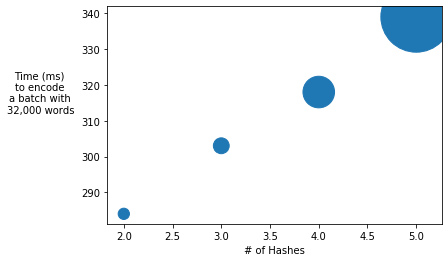

In [ ]:
plt.scatter(range(2, 6), [284, 303, 318, 339], s=[127, 251, 997, 5_003])
plt.xlabel('# of Hashes')
plt.ylabel('Time (ms) \nto encode \na batch with \n32,000 words',
           rotation=0, labelpad=40)
plt.show()

## Try memoizing hash func.

Caching results does save computation but it increases memory usage, which is one of the benefits of Bloom Embeddings. However, this is probably still more memory efficient since each word in the cache is represented by only a few indices rather than a large embedding. A large embedding matrix also forces us to devote a lot of memory to unused gradients during training (if the layer is not frozen). Still, the fact that `probabilistic_hash_tensor` is not vectorized means that it may be best to pre-compute these and load the indices in the Dataset. Rather than caching, it may be easiest to create a w2hash dict similar to a standard w2index dict. Leaving this implementation lets the user determine what tradeoff they want between speed and memory.

In [ ]:
@lru_cache(maxsize=30_000)
def probabilistic_hash_item(x, n_buckets, mode=int, n_hashes=3):
    """Slightly hacky way to probabilistically hash an integer by
    first converting it to a string.
    
    Parameters
    ----------
    x: int
        The integer or string to hash.
    n_buckets: int
        The number of buckets that items will be mapped to. Typically 
        this would occur outside the hashing function, but since 
        the intended use case is so narrow here it makes sense to me 
        to include it here.
    mode: type
        The type of input you want to hash. This is user-provided to prevent
        accidents where we pass in a different item than intended and hash 
        the wrong thing. One of (int, str). When using this inside a
        BloomEmbedding layer, this must be `int` because there are no
        string tensors. When used inside a dataset or as a one-time
        pre-processing step, you can choose either as long as you
        pass in the appropriate inputs.
    n_hashes: int
        The number of times to hash x, each time with a different seed.
        
    Returns
    -------
    list[int]: A list of integers with length `n_hashes`, where each integer
        is in [0, n_buckets).
    """
    # Check type to ensure we don't accidentally hash Tensor(5) instead of 5.
    assert isinstance(x, mode), f'Input `x` must have type {mode}.'
    return [mmh3.hash(str(x), i, signed=False) % n_buckets 
            for i in range(n_hashes)]


def probabilistic_hash_tensor(x_r2, n_buckets, n_hashes=3, pad_idx=0):
    """Hash a rank 2 LongTensor.
    
    Parameters
    ----------
    x_r2: torch.LongTensor
        Rank 2 tensor of integers. Shape: (bs, seq_len)
    n_buckets: int
        Number of buckets to hash items into (i.e. the number of 
        rows in the embedding matrix). Typically a moderately large
        prime number, like 251 or 997.
    n_hashes: int
        Number of hashes to take for each input index. This determines
        the number of rows of the embedding matrix that will be summed
        to get the representation for each word. Typically 2-5.
    pad_idx: int or None
        If you want to pad sequences with vectors of zeros, pass in an
        integer (same as the `padding_idx` argument to nn.Embedding).
        If None, no padding index will be used. The sequences must be
        padded before passing them into this function.
        
    Returns
    -------
    torch.LongTensor: Tensor of indices where each row corresponds
        to one of the input indices. Shape: (bs, seq_len, n_hashes)
    """
    return torch.tensor(
        [[probabilistic_hash_item(x.item(), n_buckets, int, n_hashes) 
          if x != pad_idx else [pad_idx]*n_hashes for x in row]
         for row in x_r2]
    )

In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 5_003, 5)

191 ms ± 12 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 5_003, 2)

185 ms ± 8.76 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
%%timeit -n 5 -r 5
hashed = probabilistic_hash_tensor(x, 5_003, 2)

195 ms ± 5.1 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [ ]:
probabilistic_hash_item.cache_info()

CacheInfo(hits=780342, misses=19633, maxsize=30000, currsize=19633)

In [ ]:
len(set(flatten(x.numpy())))

19634

In [ ]:
probabilistic_hash_item.cache_clear()

In [ ]:
probabilistic_hash_item.cache_info()

CacheInfo(hits=0, misses=0, maxsize=30000, currsize=0)